In [20]:
import exasim_plot_helpers as eph
import ipywidgets
from obr.core.queries import query_to_dataframe, query_to_records
from copy import deepcopy
import numpy as np
import pandas as pd
import ipydatagrid as grid

import seaborn
import matplotlib.pyplot as plt

In [21]:
# Notebook wide parameters
case = "WindsorBody"

In [22]:
def apply_host_specs(df):
    host_specs = {
        "nla-gpu2.ianm.kit.edu": {"NGPUS": 8, "NCORES": 32},
        "guyot": {"NGPUS": 4, "NCORES": 128}
    }
    
    host = df["host"].values[0]
    df["NGPUS"] = host_specs[host]["NGPUS"]
    df["NCORES"] = host_specs[host]["NCORES"]
    df["NCU"] = np.where(df['executor'] == "CPU", df["nSubDomains"], host_specs[host]["NGPUS"])
    df["DoFPerCU"] = df["nCells"] / df["NCU"]
    df["SolvePTimePerDoF"] = df["SolveP"] / (df["nCells"]*df["iter_p"] )
    return df


def post_pro_df(df):
    df["SolvePperIter"] = df["SolveP [ms]"]/df["Number iterations p"]
    return df.groupby("host").apply(apply_host_specs)

def generate_df(case):
    folder = "/home/go/data/code/exasim-project/benchmark_data/" + case
    jobs = eph.signac_conversion.to_jobs(folder)
    q = list(eph.signac_conversion.generate_queries())
    df = query_to_dataframe(jobs, q, index=[
        "nCells", 
        "solver_p", 
        "solver_U",
        #"precond_p", 
        #"precond_U",
        "executor", 
        "numberOfSubDomains"])#), post_pro=post_pro_df)
    df = df[df['host'].notna()]
    return df

dfs = { case:generate_df(case) for case in ["WindsorBody"]}

def update_df():
    dfs["WindsorBody"] = g.get_visible_data()
    
g = grid.DataGrid(
    dfs[case], layout={"height": "300px", "width": "1600px"}, selection_mode="cell" #, base_column_size=100
)
g.on_trait_change(update_df)
g

/tmp/ipykernel_3411205/3159599139.py:43: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  g.on_trait_change(update_df)


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [23]:
df = deepcopy(dfs[case])
df = df.reset_index()

def plot_func(x="nCells", y="SolveP [ms]", color="solver_U",column="host", style="solver_p",units=None,logx=True,logy=True,plot_type="line"):
    """Needed to pass in sensible defaults """
    eph.plot_funcs.draw_plot_faceted_plot(df, x=x,y=y, color=color,column=column,style=style,units=units,logx=logx,logy=logy,plot_type=plot_type)

ipywidgets.interact(
    plot_func,
    x=list(df.columns), 
    y=list(df.columns),
    color=list(df.columns),
    column=list(df.columns),
    units=list(df.columns),
    style=list(df.columns),
    logy=True,
    logx=True,
    plot_type=["line", "scatter"]
)

interactive(children=(Dropdown(description='x', options=('nCells', 'solver_p', 'solver_U', 'executor', 'number…

<function __main__.plot_func(x='nCells', y='SolveP [ms]', color='solver_U', column='host', style='solver_p', units=None, logx=True, logy=True, plot_type='line')>

In [24]:
df = deepcopy(dfs[case])
df = df.reset_index()

base_queries = {
    "LidDrivenCavity3D": {
        "unprecondCPU": [eph.helpers.DFQuery(idx="preconditioner", val="none"), eph.helpers.DFQuery(idx="executor", val="CPU"),],
        "GAMGCPU": [eph.helpers.DFQuery(idx="solver", val="GAMG"), eph.helpers.DFQuery(idx="executor", val="CPU"),],
    },
    "WindsorBody":{
        "GAMGCPU": [
            eph.helpers.DFQuery(idx="solver_p", val="GAMG"), 
            eph.helpers.DFQuery(idx="solver_U", val="smoothSolver"),],
        "PCGCPU": [
            eph.helpers.DFQuery(idx="solver_p", val="PCG"), 
            eph.helpers.DFQuery(idx="solver_U", val="smoothSolver"),
        ],
    }
}

def draw_plot_faceted_plot(
    x="nCells", y="TimeStep [ms]", color="solver_U", column="host",
    case=case, style="solver_p", 
    selector=[]):
    df = deepcopy(dfs[case])
    base=base_queries[case]["GAMGCPU"]
    # compute_full_node_normalize
    df = eph.helpers.compute_speedup(df, base, ignore_indices=["executor"])
    df = df.reset_index()
    
    # df.index = df.index.droplevel("host")
    # Fix color order if solver are requested
    if "solver" in color:
        colors = df[color].unique()
        hue_order = []
        for c in colors:
            if "GKO" in c:
                hue_order.append(c)
        for c in colors:
            if not "GKO" in c:
                hue_order.append(c)
                
    # Fix style order if solver are requested
    style_order = None    
    if "solver" in style:
        colors = df[style].unique()
        style_order = []
        for c in colors:
            if "GKO" in c:
                style_order.append(c)
        for c in colors:
            if not "GKO" in c:
                style_order.append(c)  

    ax = seaborn.relplot(x=x, y=y, hue=color, style=style, style_order=style_order, hue_order=hue_order, data=df, col=column, kind="line", markers=True)
    ax.set(ylabel=f"Speepup {y.replace(' [ms]', '')} [-]")
    plt.xscale('log')


ipywidgets.interact(
    draw_plot_faceted_plot,
    x=list(df.columns), 
    y=list(df.columns),
    color=list(df.columns),
    column=list(df.columns),
    style=list(df.columns),
    case=list(dfs.keys()),
)

interactive(children=(Dropdown(description='x', options=('nCells', 'solver_p', 'solver_U', 'executor', 'number…

<function __main__.draw_plot_faceted_plot(x='nCells', y='TimeStep [ms]', color='solver_U', column='host', case='WindsorBody', style='solver_p', selector=[])>

In [15]:
import pandas as pd
def draw_melted_bar_plot(x='nCells', column='executor', sel="executor", value="hip"):
    df = deepcopy(dfs[case])
    df = df.reset_index()
    melt_idx = ['MomentumPredictor [ms]', 'MatrixAssemblyU [ms]', 'MatrixAssemblyPI: [ms]', 'MatrixAssemblyPII: [ms]', 'SolveP [ms]']
    df = df[df[sel] == value]
    for m_idx in melt_idx:
        df[m_idx] = df[m_idx]/df['TimeStep [ms]']
    df = pd.melt(df,  id_vars=['nCells', 'executor', 'numberOfSubDomains', "precond_p", "solver_p"],  value_vars=melt_idx)
    seaborn.relplot(x=x, y="value", hue="variable", data=df, col=column, kind="line", markers=True)

ipywidgets.interact(
    draw_melted_bar_plot,
    x=["nCells", "nSubDomains"], 
    column=["nCells", "nSubDomains", "executor", "solver_p", "preconditioner"],
    sel=["nCells", "nSubDomains", "executor"],
    value="hip"
)

interactive(children=(Dropdown(description='x', options=('nCells', 'nSubDomains'), value='nCells'), Dropdown(d…

<function __main__.draw_melted_bar_plot(x='nCells', column='executor', sel='executor', value='hip')>

In [14]:
import pandas as pd
def draw_melted_bar_plot(x='nCells', column='executor', sel="executor", value="hip"):
    df = deepcopy(dfs[case])
    df = df.reset_index()
    melt_idx = [
       'p: update_local_matrix_data:',
       'p: update_non_local_matrix_data:', 'p_matrix: call_update:',
       'p_rhs: call_update:', 'p: init_precond:', 'p: generate_solver:',
       'p: solve:', 'p: copy_x_back:']
    df = df[df[sel] == value]
    for m_idx in melt_idx:
        df[m_idx] = df[m_idx]/df['TimeStep [ms]']
    df = pd.melt(df,  id_vars=['nCells', 'executor', 'numberOfSubDomains', "precond_p", "solver_p"],  value_vars=melt_idx)
    seaborn.relplot(x=x, y="value", hue="variable", data=df, col=column, kind="line", markers=True)

ipywidgets.interact(
    draw_melted_bar_plot,
    x=["nCells", "nSubDomains"], 
    column=["nCells", "nSubDomains", "executor", "solver_p", "preconditioner"],
    sel=["nCells", "nSubDomains", "executor"],
    value="hip"
)

interactive(children=(Dropdown(description='x', options=('nCells', 'nSubDomains'), value='nCells'), Dropdown(d…

<function __main__.draw_melted_bar_plot(x='nCells', column='executor', sel='executor', value='hip')>

In [26]:
df

,nCells,solver_p,solver_U,executor,numberOfSubDomains,Initial residual p,Final residual p,Number iterations p,Initial residual pFinal,Final residual pFinal,...,proc_p: init_precond:,time_p: init_precond:,proc_p: generate_solver:,time_p: generate_solver:,proc_p: solve:,time_p: solve:,proc_p: copy_x_back:,time_p: copy_x_back:,proc_p: solve_multi_gpu,time_p: solve_multi_gpu
0,6307136.0,GAMG,GKOBiCGStab,CPU,32.0,0.073308,0.000649,7.895833,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6307136.0,GAMG,smoothSolver,CPU,32.0,0.056872,0.000488,8.312500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6307136.0,GKOCG,GKOBiCGStab,hip,32.0,0.061387,0.000563,387.520833,NaN,NaN,...,0.0,0.283354,0.0,0.000979,0.0,504.232146,0.0,1.092000,0.0,511.843292
3,6307136.0,GKOCG,smoothSolver,hip,32.0,0.056685,0.000517,387.812500,NaN,NaN,...,0.0,0.280083,0.0,0.000854,0.0,516.120292,0.0,1.117354,0.0,523.994521
4,12614272.0,GAMG,GKOBiCGStab,CPU,32.0,0.067458,0.000566,5.645833,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12614272.0,GAMG,smoothSolver,CPU,32.0,0.056768,0.000441,5.854167,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12614272.0,GKOCG,GKOBiCGStab,hip,32.0,0.086802,0.000729,367.958333,NaN,NaN,...,0.0,0.593771,0.0,0.001271,0.0,575.481375,0.0,1.960875,0.0,588.760562
7,12614272.0,GKOCG,smoothSolver,hip,32.0,0.056701,0.000513,387.812500,NaN,NaN,...,0.0,0.607875,0.0,0.000917,0.0,612.044583,0.0,2.038146,0.0,625.292000
8,25228544.0,GAMG,GKOBiCGStab,CPU,32.0,0.064191,0.000535,5.458333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,25228544.0,GAMG,smoothSolver,CPU,32.0,0.056820,0.000456,5.687500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
import pandas as pd
def draw_melted_bar_plot(x='nCells', col='executor', sel="executor", value="hip"):
    df = deepcopy(dfs[case])
    df = df.reset_index()
    melt_idx = [
       'time_p: update_local_matrix_data:',
       'time_p: update_non_local_matrix_data:',
       'time_p_matrix: call_update:',
       'time_p_rhs: call_update:', 
       'time_p: init_precond:', 
       'time_p: generate_solver:',
       'time_p: solve:', 
       'time_p: copy_x_back:']
    df = df[df[sel] == value]
    for m_idx in melt_idx:
        df[m_idx] = df[m_idx]/df['SolveP [ms]']
    df = pd.melt(df,  id_vars=['nCells', 'executor', 'numberOfSubDomains', "precond_p", "solver_p"],  value_vars=melt_idx)
    seaborn.relplot(x=x, y="value", hue="variable", data=df, col=col, kind="line", markers=True)

ipywidgets.interact(
    draw_melted_bar_plot,
    x=["nCells", "nSubDomains"], 
    col=["nCells", "nSubDomains", "executor"],
    sel=["nCells", "nSubDomains", "executor"],
    value="hip"
)

interactive(children=(Dropdown(description='x', options=('nCells', 'nSubDomains'), value='nCells'), Dropdown(d…

<function __main__.draw_melted_bar_plot(x='nCells', col='executor', sel='executor', value='hip')>

In [9]:
dfs["LidDrivenCavity3D"]#["NCU"]

host  \
nCells     solver executor nSubDomains preconditioner                          
1000000.0  GAMG   CPU      8.0         GaussSeidel     nla-gpu2.ianm.kit.edu   
                           16.0        GaussSeidel     nla-gpu2.ianm.kit.edu   
                           32.0        GaussSeidel     nla-gpu2.ianm.kit.edu   
           GKOCG  hip      8.0         BJ              nla-gpu2.ianm.kit.edu   
                                       none            nla-gpu2.ianm.kit.edu   
...                                                                      ...   
64000000.0 PCG    CPU      8.0         none            nla-gpu2.ianm.kit.edu   
                           16.0        none            nla-gpu2.ianm.kit.edu   
                                       none            nla-gpu2.ianm.kit.edu   
                           32.0        none            nla-gpu2.ianm.kit.edu   
                                       none            nla-gpu2.ianm.kit.edu   

                                                                 campaign  \
nCells     solver executor nSubDomains preconditioner                       
1000000.0  GAMG   CPU      8.0         GaussSeidel          MVAPICH + GDR   
                           16.0        GaussSeidel          MVAPICH + GDR   
                           32.0        GaussSeidel          MVAPICH + GDR   
           GKOCG  hip      8.0         BJ                   MVAPICH + GDR   
                                       none                 MVAPICH + GDR   
...                                                                   ...   
64000000.0 PCG    CPU      8.0         none                 MVAPICH + GDR   
                           16.0        none                 MVAPICH + GDR   
                                       none            OMPI + HOST_BUFFER   
                           32.0        none            OMPI + HOST_BUFFER   
                                       none                 MVAPICH + GDR   

                                                      tags  \
nCells     solver executor nSubDomains preconditioner        
1000000.0  GAMG   CPU      8.0         GaussSeidel     nla   
                           16.0        GaussSeidel     nla   
                           32.0        GaussSeidel     nla   
           GKOCG  hip      8.0         BJ              nla   
                                       none            nla   
...                                                    ...   
64000000.0 PCG    CPU      8.0         none            nla   
                           16.0        none            nla   
                                       none                  
                           32.0        none                  
                                       none            nla   

                                                                 timestamp  \
nCells     solver executor nSubDomains preconditioner                        
1000000.0  GAMG   CPU      8.0         GaussSeidel     2023-07-11_15:23:19   
                           16.0        GaussSeidel     2023-07-11_15:16:48   
                           32.0        GaussSeidel     2023-07-11_15:16:35   
           GKOCG  hip      8.0         BJ              2023-07-05_21:34:22   
                                       none            2023-07-05_16:04:03   
...                                                                    ...   
64000000.0 PCG    CPU      8.0         none            2023-03-25_15:31:18   
                           16.0        none            2023-03-26_14:34:01   
                                       none            2023-06-27_04:33:03   
                           32.0        none            2023-06-26_12:11:17   
                                       none            2023-03-26_09:16:11   

                                                              SolveP  \
nCells     solver executor nSubDomains preconditioner                  
1000000.0  GAMG   CPU      8.0         GaussSeidel        259.8

In [54]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

a = ['Banking', 'Auto', 'Life', 'Electric', 'Technology', 'Airlines', 
'Healthcare']
df = pd.DataFrame(np.random.randn(7, 4), columns = list('ABCD'), index=a)

filtered_df = None


dropdown = widgets.SelectMultiple(
                        options=df.index,
                        description='Sector',
                        disabled=False,
                        layout={'height':'100px', 'width':'40%'})

def filter_dataframe(widget):
    global filtered_df
    selection = list(widget['new'])

    with out:
        clear_output()
        display(df.loc[selection])
        filtered_df = df.loc[selection]

out = widgets.Output()
dropdown.observe(filter_dataframe, names='value')
display(dropdown)
display(out)

SelectMultiple(description='Sector', layout=Layout(height='100px', width='40%'), options=('Banking', 'Auto', '…

Output()

In [65]:
from ipywidgets import interact, fixed

global_df = None

toy_data = pd.DataFrame({"LETTER": ["A", "B", "A","B","A", "B", "A","B"],
               "PLANT": ["Orange", "Carrots", "Lemon","Potato","Pomelo","Yam","Lime","Radish"],
               "NUMBER": [1,2,3,4,5,6,7,8]})

def inner_fn(plant, df_in):
    global_df = df_in if plant == 'ALL' else df_in[df_in['PLANT'] == plant]
    return global_df

def outer_fn(letter):
    df_ = toy_data if letter == 'ALL' else toy_data[toy_data['LETTER'] == letter]
    plants = ['ALL'] + sorted(df_['PLANT'].unique())
    interact(inner_fn, plant=plants, df_in=fixed(df_))

letters = ['ALL'] + sorted(toy_data['LETTER'].unique())
interact(outer_fn, letter=letters)

interactive(children=(Dropdown(description='letter', options=('ALL', 'A', 'B'), value='ALL'), Output()), _dom_…

<function __main__.outer_fn(letter)>

In [67]:
global_df

In [6]:
dfs["WindsorBody"]

Initial residual p  \
nCells     solver     executor numberOfSubDomains preconditioner                       
25228544.0 pimpleFoam CPU      8.0                DIC                       0.056792   
                                                  GaussSeidel               0.056828   
                                                  none                      0.056828   
                               16.0               DIC                       0.056806   
                                                  GaussSeidel               0.056823   
...                                                                              ...   
NaN        PCG        CPU      16.0               DIC                       0.056796   
                                                  DIC                       0.056701   
                               32.0               DIC                       0.056732   
                                                  DIC                       0.056722   
                                                  DIC                       0.056771   

                                                                  Final residual p  \
nCells     solver     executor numberOfSubDomains preconditioner                     
25228544.0 pimpleFoam CPU      8.0                DIC                     0.000560   
                                                  GaussSeidel             0.000456   
                                                  none                    0.000456   
                               16.0               DIC                     0.000561   
                                                  GaussSeidel             0.000454   
...                                                                            ...   
NaN        PCG        CPU      16.0               DIC                     0.000559   
                                                  DIC                     0.000560   
                               32.0               DIC                     0.000558   
                                                  DIC                     0.000560   
                                                  DIC                     0.000561   

                                                                  Number iterations p  \
nCells     solver     executor numberOfSubDomains preconditioner                        
25228544.0 pimpleFoam CPU      8.0                DIC                      122.208333   
                                                  GaussSeidel                5.791667   
                                                  none                       5.791667   
                               16.0               DIC                      118.937500   
                                                  GaussSeidel                5.687500   
...                                                                               ...   
NaN        PCG        CPU      16.0               DIC                      119.791667   
                                                  DIC                      119.833333   
                               32.0               DIC                      119.979167   
                                                  DIC                      118.583333   
                                                  DIC                      120.500000   

                                                                  Initial residual pFinal  \
nCells     solver     executor numberOfSubDomains preconditioner                            
25228544.0 pimpleFoam CPU      8.0                DIC                                 NaN   
                                                  GaussSeidel                         NaN   
                                                  none                                NaN   
                               16.0               DIC                                 NaN   
                                                  GaussSeidel                         

In [48]:
d = {"speedup": [1.5, 3.2,5,14],
    "timestamp": [pd.Timestamp(year=2021, month=10, day=1), pd.Timestamp(year=2022, month=1, day=1),pd.Timestamp(year=2023, month=2,day=1), pd.Timestamp(year=2023, month=7,day=1)]}

In [57]:
df = pd.DataFrame(d)
df = df.set_index(["timestamp"])

Text(0.5, 0, '')

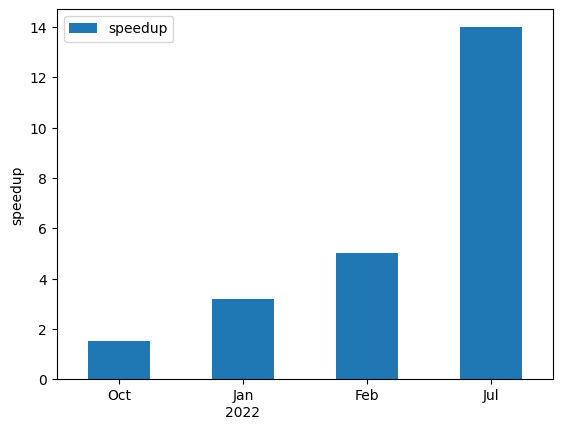

In [61]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month


ax = df.plot(kind="bar", rot=0)
ax.set_xticklabels(map(line_format, df.index))
ax.set_ylabel("speedup")
ax.set_xlabel("")

In [38]:
d

{'speedup': [3.2, 8, 15],
 'timestamp': [Timestamp('2022-01-01 00:00:00'),
  Timestamp('2023-02-01 00:00:00'),
  Timestamp('1970-01-01 00:00:00.000002023')]}

In [56]:
df

,speedup,timestamp
0,1.5,2021-10-01
1,3.2,2022-01-01
2,5.0,2023-02-01
3,14.0,2023-07-01
